In [233]:
!pip install \
    langchain-core==0.3.78 \
    langchain==0.3.27 \
    langchain-community==0.3.18 \
    langchain-text-splitters==0.3.9 \
    langchain-openai==0.3.35 \
    langgraph==0.2.68 \
    langchain-huggingface==0.1.2 \
    numpy==1.26.4 \
    "unstructured[pdf]==0.10.30" \
    pypdf==3.17.1 \
    langchain-groq==0.3.8

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [234]:
!pip install rank_bm25
!pip install langchain_postgres
!pip install wikipedia

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [235]:
import os
from pathlib import Path
from typing import Literal

from pydantic import BaseModel, Field

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import MessagesState, StateGraph, END, START
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool, render_text_description_and_args

from langchain_core.prompts import (
    ChatPromptTemplate,
)
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

from IPython.display import Image, display

In [236]:
from typing import Annotated
from typing_extensions import TypedDict, List

In [237]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("API_KEY")

In [238]:
model_path = "intfloat/multilingual-e5-base"

In [239]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    api_key=api_key,
    temperature=0.3,
)

In [240]:
def display_graph(graph: CompiledStateGraph):
    display(Image(graph.get_graph().draw_mermaid_png()))

# RAG (tool 1)

## Grounding pipeline

In [241]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import InMemoryVectorStore
from langchain_huggingface import HuggingFaceEmbeddings
from transformers import AutoTokenizer

In [242]:
from langchain_community.retrievers import BM25Retriever
from langchain.schema import Document
import re

In [243]:
class GroundingState(TypedDict, total=False):
    documents: List
    chunks: List
    vector_store: any
    status: str
    bm25_retriever: any

In [244]:
hf_model = HuggingFaceEmbeddings(
    model_name=model_path,
    encode_kwargs={
        "batch_size": 8
    }
)

In [245]:
def load_documents(state: GroundingState):
    pdf_dir = Path("/kaggle/input/lpnu-docs")
    docs = []
    
    for pdf_file in pdf_dir.glob("**/*.pdf"):
        loader = PyPDFLoader(str(pdf_file))
        file_docs = loader.load()
        docs.extend(file_docs)
    print(f"Created {len(docs)} docs")
    return {"documents": docs, "status": "loaded"}

In [246]:
def chunk_documents(state: GroundingState):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    
    splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer=tokenizer,
        chunk_size=500,
        chunk_overlap=100
    )
    chunks = splitter.split_documents(state["documents"])
    print(f"Created {len(chunks)} chunks")
    return {"chunks": chunks, "status": "chunked"}

In [247]:
def index_documents(state: GroundingState):
    docs = state["chunks"]
    print(f"Indexing {len(docs)} chunks...")
    vector_store = InMemoryVectorStore.from_documents(
        docs,
        hf_model
    )
    return {"vector_store": vector_store, "status": "indexed"}

In [248]:
def create_bm25_retriever(state: GroundingState):
    docs = state["chunks"] 
    
    bm25_retriever = BM25Retriever.from_documents(docs)
    bm25_retriever.k = 5
    return {"bm25_retriever": bm25_retriever}

In [249]:
grounding_graph = StateGraph(GroundingState)
grounding_graph.add_node("load", load_documents)
grounding_graph.add_node("chunk", chunk_documents)
grounding_graph.add_node("index", index_documents)
grounding_graph.add_node("bm25", create_bm25_retriever)

grounding_graph.add_edge("load", "chunk")
grounding_graph.add_edge("chunk", "index")
grounding_graph.add_edge("index", "bm25")
grounding_graph.add_edge("bm25", END)

grounding_graph.set_entry_point("load")
grounding_pipeline = grounding_graph.compile()

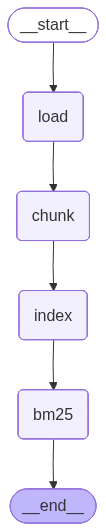

In [250]:
display_graph(grounding_pipeline)

In [251]:
initial_state = {
    "documents": [],
    "chunks": [],
    "vector_store": None,
    "status": "",
    "bm25": None
}

result = grounding_pipeline.invoke(initial_state)
vector_store = result['vector_store']
bm25_retriever = result['bm25_retriever']

Created 454 docs
Created 939 chunks
Indexing 939 chunks...


## QA pipeline

In [252]:
@tool
def retrieve(query: str, top_k=5):
    """
    Retrieve top_k documents from the vector store using semantic search.
    """
    retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"k":top_k, "lambda_mult":0.5})
    semantic_docs = retriever.invoke(query)

    context = "\n\n---\n\n".join([
        f"Документ {i+1}:\n{doc.page_content}" 
        for i, doc in enumerate(semantic_docs)
    ])
    
    return context

# Wiki (tool 2) 

In [253]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

In [254]:
wiki = WikipediaQueryRun(
    name="wikipedia",
    description="Пошук інформації у Вікіпедії. Використовуй для питань про математичні об'єкти, формули, поняття тощо.",
    api_wrapper=WikipediaAPIWrapper(
        top_k_results=3,
        lang="uk",
        doc_content_chars_max=500
    )
)

In [255]:
from langchain.agents import Tool

def wikipedia_wrapper(query: str):
    return wiki.run(query)

wiki_tool = Tool(
    name="wikipedia",
    func=wikipedia_wrapper,
    description="Пошук інформації у Вікіпедії для математичних понять, формул, тощо."
)

In [256]:
@tool
def wikipedia_search(query: str):
    """
    Search information in wikipedia
    """
    try:
        wiki = WikipediaQueryRun(
            api_wrapper=WikipediaAPIWrapper(
                top_k_results=2,
                lang="uk",
                doc_content_chars_max=500
            )
        )
        return wiki.run(query)
    except Exception as e:
        return f"Не вдалося знайти інформацію: {str(e)}"

# Agent

In [257]:
class AgentResponse(BaseModel):
    answer: str
    confidence: str
    sources: str

In [258]:
tools = [retrieve, wikipedia_search]

In [259]:
llm_with_tools = llm.bind_tools(tools)

In [260]:
class CustomMessagesState(MessagesState):
    used_tools: list[str] = []
    is_relevant: bool = True

In [261]:
def generate_structured_response(state: CustomMessagesState):
    messages = state["messages"]
    used_tools = state.get("used_tools", [])
    
    conversation_summary = "\n".join([
        f"{msg.type}: {msg.content}" if hasattr(msg, 'content') else str(msg)
        for msg in messages[-5:] 
    ])
    
    if "retrieve" in used_tools:
        sources = "NULP_docs"
    elif "wikipedia_search" in used_tools:
        sources = "Wikipedia"
    else:
        sources = "None"
    
    prompt = f"""На основі наступної розмови, створи фінальну відповідь:

{conversation_summary}

Використаний інструмент: {sources}

Відповідь має бути структурованою."""
    
    structured_llm = llm.with_structured_output(AgentResponse)
    structured_response = structured_llm.invoke([HumanMessage(content=prompt)])
    structured_response.sources = sources
    
    formatted = f"""
Відповідь: {structured_response.answer}
Використаний інструмент: {structured_response.sources}
"""
    
    return {"messages": [AIMessage(content=formatted)]}

In [262]:
def assistant(state: CustomMessagesState):
    system_prompt = """Ти - розумний асистент, який допомагає з питаннями про навчання та математику.

У тебе є ДВА інструменти:
1. **retrieve** - для пошуку в документах НУЛП (навчальні процеси)
2. **wikipedia** - для пошуку математичних понять, формул, теорем

ВАЖЛИВО:
- Для питань про навчання в університеті → використовуй retrieve
- Для математичних питань (теореми, формули) → використовуй wikipedia
- Можеш використати ОБИДВА інструменти, якщо потрібно

Завжди давай конкретні, інформативні відповіді на основі знайденої інформації."""

    messages_with_system = [SystemMessage(content=system_prompt)] + state["messages"]
    
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(messages_with_system)
    
    return {
        "messages": [response]
    }

In [263]:
def check_relevance(state: CustomMessagesState):
    query = state["messages"][-1].content
    docs = state.get("context", [])
    
    context_preview = "\n".join([doc.page_content for doc in docs])
    
    relevance_prompt = f"""
Ти — суворий класифікатор.

Твоє завдання — визначити, чи може ТЕОРЕТИЧНО питання бути пов’язане з однією з цих тем.

Теми:
- Навчальна діяльність
- Коротке визначення математичних об’єктів чи формул тощо

Питання: {query}

ВІДПОВІДАЙ ТІЛЬКИ:
- "так" — якщо питання прямо або опосередковано стосується якоїсь з тем
- "ні" - якщо питяння стосується всього іншого

Будь суворим.

Відповідь ТІЛЬКИ одним словом: так або ні
"""

    response = llm.invoke([HumanMessage(content=relevance_prompt)])
    answer = response.content.strip().upper()
    answer = re.sub(r"[^a-zA-Zа-яА-ЯіїєІЇЄ]", "", response.content).upper()
    is_relevant = answer.startswith("ТАК") or answer.startswith("YES")
    
    return {
        "is_relevant": is_relevant
    }

In [264]:
def reject_query(state: CustomMessagesState):
    rejection_message = AIMessage(content="""Вибачте, але я не можу відповісти на це запитання, оскільки воно не стосується тематики навчання, освітніх процесів або математики. 

Я можу допомогти з питаннями про:
- Організацію навчального процесу
- Математичні питання

Будь ласка, поставте питання в межах цих тематик.""")
    
    return {
        "messages": [rejection_message]
    }

In [265]:
def should_continue(state: CustomMessagesState):
    last = state["messages"][-1]

    if hasattr(last, 'tool_calls') and last.tool_calls:
        return "tools"
    
    return "generate_structured"

In [266]:
def route_based_on_relevance(state: CustomMessagesState):
    if state.get("is_relevant", True):
        return "agent"
    else:
        return "reject_query"

In [267]:
def tools_node(state: CustomMessagesState):
    tool_executor = ToolNode(tools)
    result = tool_executor.invoke(state)
    
    used_tools = state.get("used_tools", [])

    for msg in result["messages"]:
        if hasattr(msg, 'name') and msg.name:
            if msg.name not in used_tools:
                used_tools.append(msg.name)
            
            print(f"\n[Інструмент: {msg.name}]")
            if hasattr(msg, 'content') and msg.content:
                content = str(msg.content)
                if len(content) > 200:
                    print(f"{content[:200]}...")
                else:
                    print(content)
    
    return {
        "messages": result["messages"],
        "used_tools": used_tools
    }

In [268]:
agent_graph = StateGraph(CustomMessagesState)

agent_graph.add_node("agent", assistant)
agent_graph.add_node("check_relevance", check_relevance)
agent_graph.add_node("tools", tools_node)
agent_graph.add_node("generate_structured", generate_structured_response)
agent_graph.add_node("reject_query", reject_query)

agent_graph.set_entry_point("check_relevance")

agent_graph.add_conditional_edges(
    "check_relevance",
    route_based_on_relevance,
    {
        "agent": "agent",
        "reject_query": "reject_query"
    }
)
agent_graph.add_edge("reject_query", END)

agent_graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        "generate_structured": "generate_structured"
    }
)

agent_graph.add_edge("tools", "agent")

agent_graph.add_edge("generate_structured", END)

memory = InMemorySaver()
graph = agent_graph.compile(checkpointer=memory)

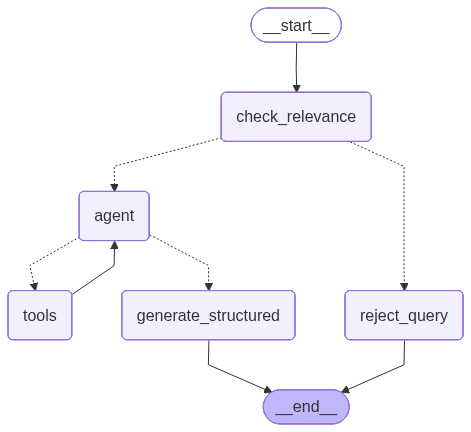

In [269]:
display_graph(graph)

# Test

In [270]:
def ask_agent(question: str, thread_id: str = "default"):
    print(f"Query: {question}")
    
    config = {"configurable": {"thread_id": thread_id}}
    
    result = graph.invoke(
        {"messages": [HumanMessage(content=question)]},
        config=config
    )
    
    final_message = result["messages"][-1].content
    print(f"\n{final_message}")

In [271]:
ask_agent("Які основні форми організації навчального процесу передбачені у Львівській політехніці (лекції, практичні, лабораторні, семінари тощо)?", thread_id="test_1")

Query: Які основні форми організації навчального процесу передбачені у Львівській політехніці (лекції, практичні, лабораторні, семінари тощо)?

[Інструмент: retrieve]
Документ 1:
Національний університет «Львівська політехніка»  
Система внутрішнього забезпечення якості освітньої діяльності та 
якості вищої освіти  
Положення про порядок підготовки здобувачів 
вищо...


Відповідь: Основні форми організації навчального процесу у Львівській політехніці включають лекції, практичні заняття, лабораторні роботи, семінари тощо. Також університетом передбачені індивідуальні графіки навчання, самостійна робота студентів, курсові проекти та інші форми організації освітнього процесу.
Використаний інструмент: NULP_docs



In [272]:
ask_agent("Що таке теорема Піфагора?", thread_id="test_2")

Query: Що таке теорема Піфагора?

[Інструмент: wikipedia_search]
Page: Теорема Піфагора
Summary: Теоре́ма Піфаго́ра (Пітаго́ра) — одна із засадничих теорем евклідової геометрії, яка встановлює співвідношення між сторонами прямокутного трикутника. Уважається, що її ...

[Інструмент: wikipedia_search]
Page: Теорема Піфагора
Summary: Теоре́ма Піфаго́ра (Пітаго́ра) — одна із засадничих теорем евклідової геометрії, яка встановлює співвідношення між сторонами прямокутного трикутника. Уважається, що її ...


Відповідь: Теорема Піфагора - це математична теорема, яка встановлює співвідношення між сторонами прямокутного трикутника. Вона говорить про те, що квадрат довжини гіпотенузи (найдовшої сторони трикутника) дорівнює сумі квадратів довжин двох інших сторін. Формула теореми Піфагора: a^2 + b^2 = c^2, де a і b - довжини двох сторін трикутника, а c - довжина гіпотенузи.
Використаний інструмент: Wikipedia



In [273]:
ask_agent("Як приготувати борщ?", thread_id="test_3")

Query: Як приготувати борщ?

Вибачте, але я не можу відповісти на це запитання, оскільки воно не стосується тематики навчання, освітніх процесів або математики. 

Я можу допомогти з питаннями про:
- Організацію навчального процесу
- Математичні питання

Будь ласка, поставте питання в межах цих тематик.
